In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.optimize import minimize

from sklearn.datasets import (
    make_moons, fetch_covtype,
    load_breast_cancer, load_boston)
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_validate, GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import (
    DecisionTreeClassifier, ExtraTreeClassifier)
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, roc_curve, auc)
from xgboost import XGBClassifier
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier,
    Ridge, BayesianRidge)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from GPy.models import GPRegression
from GPy.kern import (
    RBF, Poly, StdPeriodic, White, Linear,PeriodicExponential)
from sklearn.metrics import r2_score

# Home Assignment No. 2: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1.1. Boosting, part 1. (2 points)


> Boosting Machines (BM) are a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: firstly we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is acheived by reweighting the training samples during each algorithm's step. 

#### The task:

In this exercise you will be asked to implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. The key steps are:

* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

The pseudocode for AdaBoost can be found in [Lecture 7](https://github.com/adasegroup/ML2020_lectures).

##### criteria

the decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit` :

$$
    |\text{your_accuracy} - \text{sklearn_accuracy}| \leq 0.005
\,. $$

#### Place for ypur solution

In [2]:
### Plot the dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

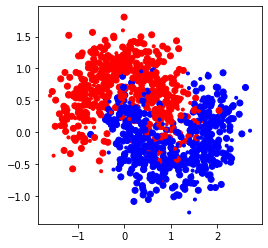

In [4]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright);

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers
* `ada_boost_distribution` - function, which calculates sample weights

Implement these procedures

In [5]:
### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm
def ada_boost_alpha(y, y_pred, distribution):
    """
    y_pred is a prediction of the last base classifier
    """
    N_T = distribution[y*y_pred <= 0].sum()
    alpha = .5*np.log((1-N_T)/N_T)
    return alpha

In [6]:
def ada_boost_distribution(y, y_pred, distribution, alpha):
    """
    y_pred is a prediction of the last base classifier
    """
    distribution *= np.exp(-alpha*y*y_pred)
    distribution /= distribution.sum()

Our custom boosting class

In [7]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators:    int, number of estimators (number of boosting rounds)
    :param base_classifier:     callable, a function that creates a weak estimator.
                                Weak estimator should support sample_weight argument
                                
    :param get_alpha:    callable, a function, that calculates new alpha
                         given current distribution, prediction of the t-th base estimator,
                         boosting prediction at step (t-1) and actual labels
                         
    :param get_distribution:    callable, a function, that calculates samples weights
                                given current distribution, prediction, alphas and actual labels
    """
    def __init__(
        self, n_estimators=50, base_classifier=None, 
        get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples) / n_samples
        self.classifiers = []
        self.alphas = np.empty(self.n_estimators)
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            # ======= Your code here ======
            
            # make a prediction
            y_pred = self.classifiers[-1].predict(X)
            
            #update alphas, append new alpha to self.alphas
            alpha = self.get_alpha(y, y_pred, distribution)
            self.alphas[i] = alpha
            
            # update distribution and normalize
            self.update_distribution(y, y_pred, distribution, alpha)
    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        pred_list = list(map(lambda m: m.predict(X), self.classifiers))
        return np.sign(np.dot(self.alphas, pred_list))

In [8]:
max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost1 = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost1.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train);

In [9]:
classifiers = [ada_boost1, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.875
accuracy ada_boost_sklearn: 0.875


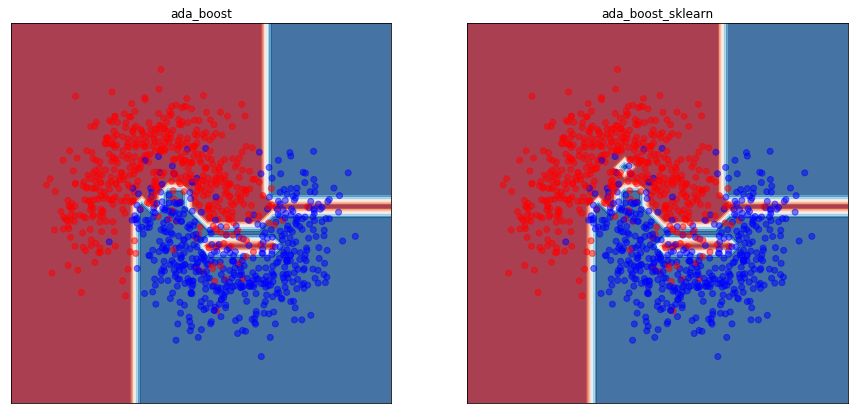

In [10]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction==y_test).sum() * 1./len(y_test)))

## Task 1.2. Boosting, part 2. (2 points)

For adaboost we have computed each alpha according to the formula:

$$\alpha_t = \frac{1}{2}\log{\frac{1-N_T(h_T, w_T )}{N_T(h_T,w_t)}}$$

In the next task you will be asked to instead recompute all of the alphas after adding another estimator to the composition of models, i.e. when the new classifier is fitted to the weighted data samples, the new alphas should be recomputed by directly minimizing the exponential loss, for all the avaliable estimators. Take into account, that at each step of the boosting algorithm **all** alphas and, consequntly, **all** sample weights should be recomputed from scratch. 

**The task**:
* Complete the `recompute_alpha` and `recompute_distribution` functions
* Complete the `.fit` method of `RecomputeBoosting` class
* Complete the `.predict` method of `RecomputeBoosting` class
* Plot the final alphas (last calculated in case of recomputed alphas)
* plot the history scores of the resulting model at each iteration (use ```predict```, ```score``` and ```construct_alpha_history``` functions defined below) for both RecomputedBoosting and AdaBoost (it can be either your own implementation from Exercise 1.1 or the one from sklearn - in this case use ```.estimator_weights_```, ```.estimators_```)
* Make a conclusion about which method is better and in which case - in order to do that you can additionally vary the parameters of training: number and depth of the estimators, noise of the data (moons)

**HINTS:**

In order to minimize the exponential loss with respect to alpha, use the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

When defining the function to minimize (in case of AdaBoost it should be the exponential loss), have a look at the optimization problem formulation of Ridge Regression and at the reguralization parameter([Lecture 2, slide 14](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture2/Lecture_2_Regression.pdf)). Add it in order to guarantee the existence of the solution.

In [11]:
def recompute_alpha(y, y_pred, C):
    """
    y_pred - is a list of predictions of the existing estimators
    C - is a reguralization term    
    """
    # ====== Your code here =====
    fn = lambda x: np.exp(-np.dot(x,y_pred)*y).mean() + C*x@x
    fun_jac = lambda x: -np.mean(np.exp(-np.dot(x,y_pred)*y)*y*y_pred, 1) + 2*C*x
    # As `x` here we denote our alphas
    x0 = np.full(len(y_pred), 1./len(y_pred))
    res = minimize(fn, x0, jac=fun_jac, method='CG')
    return res.x 
    

def recompute_distribution(y, y_pred, alphas):
    """
    y_pred - is a list of predictions of the existing estimators
    alphas - are the last recomputed alphas
    """
    # ====== Your code here =====
    distribution = np.exp(-y*np.dot(alphas,y_pred))
    return distribution / distribution.sum()

In [12]:
class RecomputedBoosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator.
                            Weak estimator should support sample_weight argument
                            
    :param get_alpha: callable, a function, that calculates new alpha
                      given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
                      
    :param get_distribution: callable, a function, that calculates samples weights
                             given current distribution, prediction, alphas and actual labels
    """
    def __init__(
        self, n_estimators=50, base_classifier=None,
        get_alpha=recompute_alpha, update_distribution=recompute_distribution, C=1.):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        self.C = C
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples) / n_samples
        pred_list = np.array([]).reshape(-1, len(y))
        self.classifiers = []
        
        # notice how alpha is a matrix - we will store the history of the updates here
        self.alphas = np.zeros((n_estimators, n_estimators))
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())        
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            # ======= Your code here ======
            # create a list of predictions across all classifiers
            y_pred = self.classifiers[-1].predict(X)
            pred_list = np.vstack((pred_list, y_pred))

            # recalculate alphas, add them to the matrix of self.alphas 
            # NOTE: here, self.alphas is a history of computed alphas at each step i
            alphas = self.get_alpha(y, pred_list, self.C)
            self.alphas[i,:len(alphas)] = alphas
            
            # update distribution and normalize
            distribution = self.update_distribution(y, pred_list, alphas)
    
    def predict(self, X):
        # ====== Your code here ======
        # get the weighted votes of the classifiers
        # do not forget: self.alphas is the whole history of recalculated alphas!
        pred_list = list(map(lambda m: m.predict(X), self.classifiers))
        return np.sign(np.dot(self.alphas[-1], pred_list))

In [13]:
%%time
ada_boost2 = RecomputedBoosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                     update_distribution=recompute_distribution, C=1.0)
ada_boost2.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train);
pass

CPU times: user 2.71 s, sys: 35.2 ms, total: 2.74 s
Wall time: 736 ms


In [14]:
classifiers = [ada_boost2, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.92
accuracy ada_boost_sklearn: 0.875


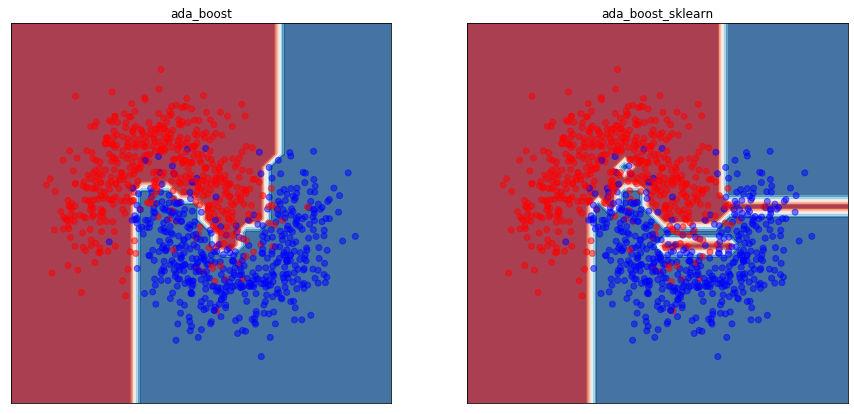

In [15]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i+1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1./len(y_test)))

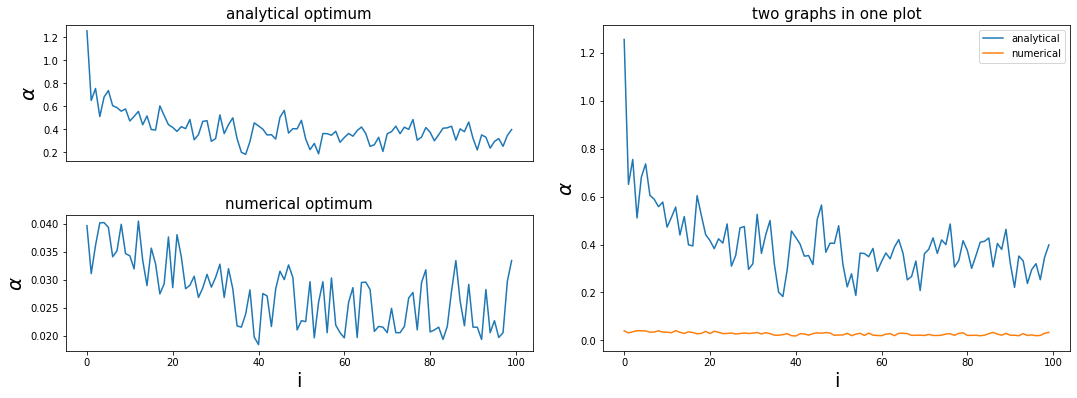

In [16]:
## Plot the resulting alphas (last calculated in case of recomputed alphas)
plt.figure(figsize=(18, 6))
gs = plt.GridSpec(2, 2, wspace=.15, hspace=.4)

plt.subplot(gs[0, 0])
plt.plot(ada_boost1.alphas)
plt.title('analytical optimum', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=20)
plt.xticks([])

plt.subplot(gs[1:, 0])
plt.plot(ada_boost2.alphas[-1]);
plt.title('numerical optimum', fontsize=15)
plt.xlabel('i', fontsize=20)
plt.ylabel(r'$\alpha$', fontsize=20)

plt.subplot(gs[0:, 1:])
plt.plot(ada_boost1.alphas, label='analytical')
plt.plot(ada_boost2.alphas[-1], label='numerical')
plt.title('two graphs in one plot', fontsize=15)
plt.xlabel('i', fontsize=20)
plt.ylabel(r'$\alpha$', fontsize=20)

plt.legend();

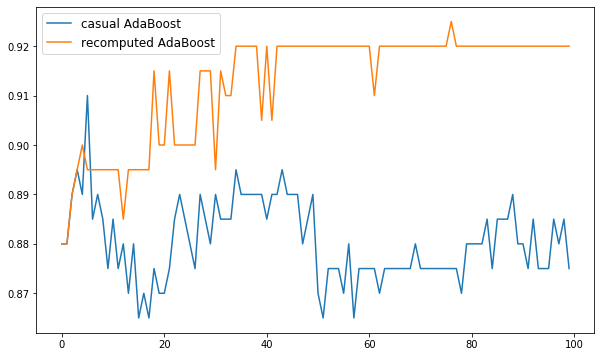

In [17]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
## for AdaBoost and RecomputedAdaBoost

def get_scores(alphas, estimators, X, y):
    pred_list = list(map(lambda m: m.predict(X), estimators))
    acum_pred = np.sign((alphas[:, None]*pred_list).cumsum(0))
    return [accuracy_score(y, y_pred) for y_pred in acum_pred]

score1 = get_scores(ada_boost1.alphas, ada_boost1.classifiers, X_test, y_test)
score2 = get_scores(ada_boost2.alphas[-1], ada_boost2.classifiers, X_test, y_test)

plt.figure(figsize=(10, 6))
plt.plot(score1, label='casual AdaBoost')
plt.plot(score2, label='recomputed AdaBoost')
plt.legend(fontsize=12);

Make a conclusion about which method is better and in which case. 

Your answer

## Task 2. Gradient Boosting and Feature Selection (1 point)

Gradient Boosting Machines (GBM) are a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are the extremely powerful tools, widely used in industry, research and various machine learning competitions. 

In this task we offer to focus on one varinat of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is  [Telecom Churn Dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). You will need to construct an XGBoost classification model, train it, plot the ROC curve, measure the training time and compare it to Random Forest. Afterwards, compare the models' feature importances. 

**The task**
* train the XGBoost classifier on the provided dataset
  * measure the training time
  * measure the precision/recall on the test set
  * plot ROC-curve

* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

* compare the feature importances of the trained XGBoost and Random Forest Classifiers. Why do you think they are different? Explain.

* for each model, sort the features by their importance, and plot the dependence of the test score on the number of features selected by best importance

* Fit the models to the iteratively reduced subset of features -in order to do that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall.

**HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

Make sure that you have installed the XGBoost package before starting the task. 

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [18]:
data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0x0BADBEEF)

* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

In [19]:
###YOUR CODE###
XGB = XGBClassifier(max_depth=2, n_jobs=-1)
RFC = RandomForestClassifier(max_depth=10, n_jobs=-1)

index = []
elapsed_time = []
P_score, R_score = [], []
Pr = []

for C in [XGB, RFC]:
    index.append(C.__class__.__name__)
    t = %timeit -oq C.fit(X_train, y_train)
    elapsed_time.append(t.best)
    
    y_pred = C.predict(X_test)
    P_score.append(precision_score(y_test, y_pred))
    R_score.append(recall_score(y_test, y_pred))
     
    Pr.append(C.predict_proba(X_test))

In [20]:
data_dict = {'Runtime': elapsed_time, 'Precision': P_score, 'Recall': R_score}
cols = list(data_dict.keys())
res = pd.DataFrame(data_dict, index=index)

percent = lambda x: '{:.0f}%'.format(x*100)
res[cols[1:]] = res[cols[1:]].applymap(percent)
res.Runtime = res.Runtime.apply('{:.3f}'.format)

def highlight_max(x):
    return ['color:green' if v else '' for v in (x>x.min())]
def highlight_min(x):
    return ['color:green' if v else '' for v in (x<x.max())]

res.style.apply(
    highlight_max, subset=cols[1:]).apply(
    highlight_min, subset=cols[0])

,Runtime,Precision,Recall
XGBClassifier,0.102,84%,52%
RandomForestClassifier,0.164,95%,45%


XGBClassifier		AUC=0.875
RandomForestClassifier	AUC=0.865


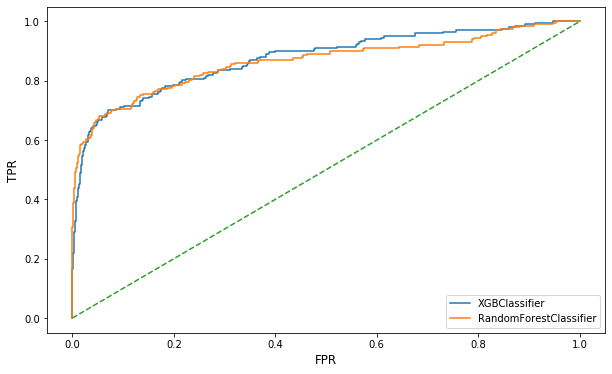

In [21]:
plt.figure(figsize=(10, 6))
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test, Pr[i][:,1])
    indent = (2-i)*'\t'
    print(f'{index[i]}{indent}AUC={auc(fpr, tpr):.3}')
    plt.plot(fpr, tpr, label=index[i])
    
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.plot([0, 1], '--')
plt.legend(loc=4);

* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?

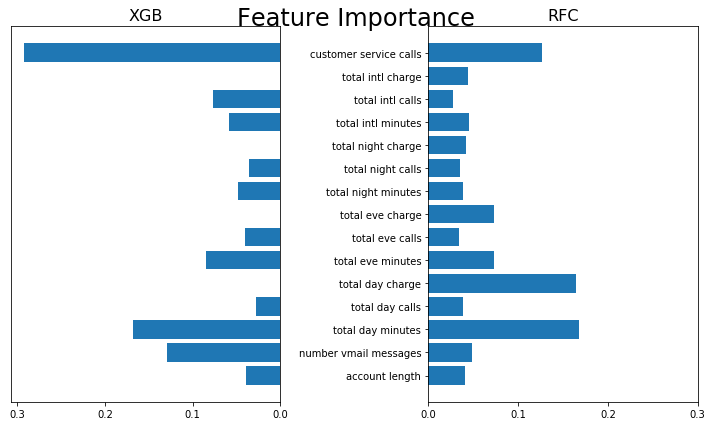

In [22]:
###YOUR CODE###
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Feature Importance', size=24)
ax1.barh(data.columns[:-1], -XGB.feature_importances_)
ax1.set_title('XGB', size=16)
ax1.set_yticks([])

ax2.barh(data.columns[:-1], RFC.feature_importances_)
ax2.set_title('RFC', size=16)
xmax = round(np.r_[np.abs(ax1.get_xticks()), ax2.get_xticks()].max(), 2)

ticks = np.arange(0., xmax, .1)
tick_lbls = list(map(lambda x: f'{x:.2}', ticks))

ax1.set_xticks(-ticks)
ax2.set_xticks(ticks)
ax1.set_xticklabels(tick_lbls)
ax2.set_xticklabels(tick_lbls)

plt.tight_layout();

***Obviously, they are different. XGB does not take into account some of the features, while RFC does. Magnitudes are different as well***

* Fit the models to the iteratively reduced subset of features - in order to do that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

**Note**:  
*xgboost* version 1.0.2  
*scikit-learn* version 0.22.1  

`.coef_` method of a XGBClassifier instance raises `KeyError: 'weight'` if non-linear Booster type is in use.

`SelectFromModel` uses `_get_feature_importances` function. The latter contains line: `coef_ = getattr(estimator, 'coef_', None)`, which leads to the aforementioned error. I substituted it with the code below:

```python
try: coef_ = getattr(estimator, "coef_")
except: coef_ = None
```
Path to `_get_feature_importances` can be obtained from `SelectFromModel`'s docstring

In [23]:
###YOUR CODE###
P, R = {}, {}
params = [{'max_depth': 2}, {'max_depth': 10}]
for i,C in enumerate([XGB, RFC]):
    thresholds = np.sort(C.feature_importances_)[::-1]
    selector = SelectFromModel(C, prefit=True)

    P[i], R[i] = map(np.array, ([], []))
    C_copy = C.__class__(**params[i], n_jobs=-1)
    for theta in thresholds:
        if theta < 1e-12: break 
        selector.threshold = theta
        X_tr_train = selector.transform(X_train)
        X_tr_test = selector.transform(X_test)
        C_copy.fit(X_tr_train, y_train)

        y_pred = C_copy.predict(X_tr_test)
        P[i] = np.r_[P[i], precision_score(y_test, y_pred)]
        R[i] = np.r_[R[i], recall_score(y_test, y_pred)]

**I am not sure what is meant by 'plot the precision-recall'. Below is my interpretation of it**

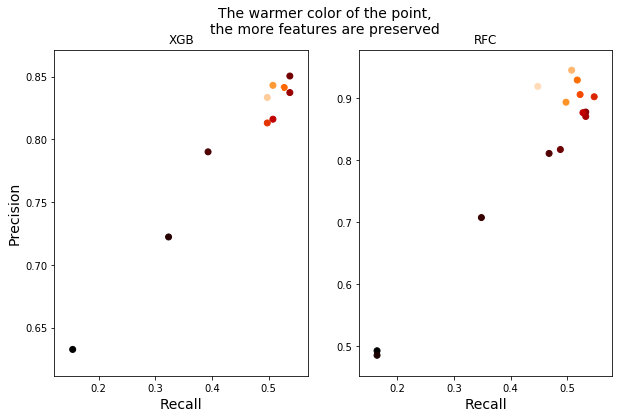

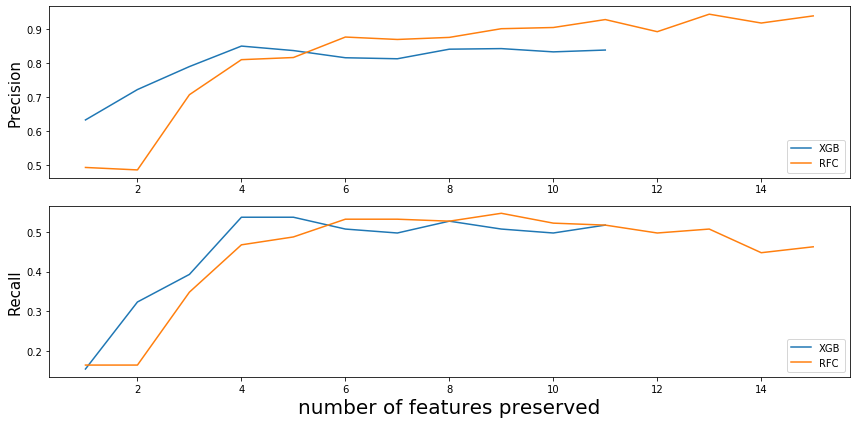

In [24]:
cm = [plt.cm.gist_heat(np.linspace(0, 1, len(R[0]))),
      plt.cm.gist_heat(np.linspace(0, 1, len(R[1])))]

fig, ax = plt.subplots(1, 2, figsize=(10,6))

estimator = ['XGB', 'RFC']
metric = ['Precision', 'Recall']
plt.suptitle(
    'The warmer color of the point,'
    '\nthe more features are preserved', size=14)
for i, name in enumerate(estimator):
    ax[i].set_title(name)
    ax[i].scatter(R[i], P[i], c=cm[i])
    ax[i].set_xlabel('Recall', size=14)
ax[0].set_ylabel('Precision', size=14);

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
for i, name in enumerate(metric):
    ax[0].plot(np.arange(1, len(P[i])+1), P[i], label=estimator[i])
    ax[1].plot(np.arange(1, len(R[i])+1), R[i], label=estimator[i])
    ax[i].set_ylabel(name, fontsize=15)
    
for i in range(2):
    ax[i].legend(loc=4)
ax[1].set_xlabel('number of features preserved', fontsize=20)
plt.tight_layout();


# Task 3. Bayesian methods (1 point)

In this task you are asked to compare the performance of the common Ridge Regression with the parameters chosen using cross-validation technique and Bayesian Ridge Regression. 

In particular, using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html), find the optimal value for the reguralization coefficient in the ridge regression optimization problem formulation. Then train [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) and compare the absolute error and learnt coefficients distribution for both variants and make some conclusions on both methods.

**The task:** 
* Use crossvalidation technique to choose the optimal value of reguralization coefficent for Ridge Regression model. (**Note:** "optimal" value here, means the one that lets the model with this particular parameter value achieve better performance compared to the other variants). 
* Fit Bayesian Ridge Regression model 
* Plot the absolute error historgramms for both models using [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).
* Plot historgrams of coefficients of regression derived from both models (in cross-validation case the coefficients of the best model)
* Compare the two pairs of histrograms. Are they the same or different? Why? What are the prons and cons of both methods?

In [25]:
X,y = load_boston(return_X_y=True)
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

In [26]:
###YOUR CODE###
params = {'alpha': np.linspace(1, 1000, 5000)}
model = GridSearchCV(Ridge(), params).fit(X_train, y_train)
rr_error = np.abs(model.predict(X_test) - y_test)
rr = Ridge(model.best_params_['alpha']).fit(X_train, y_train)

brr = BayesianRidge().fit(X_train, y_train)
brr_error = np.abs(brr.predict(X_test) - y_test)

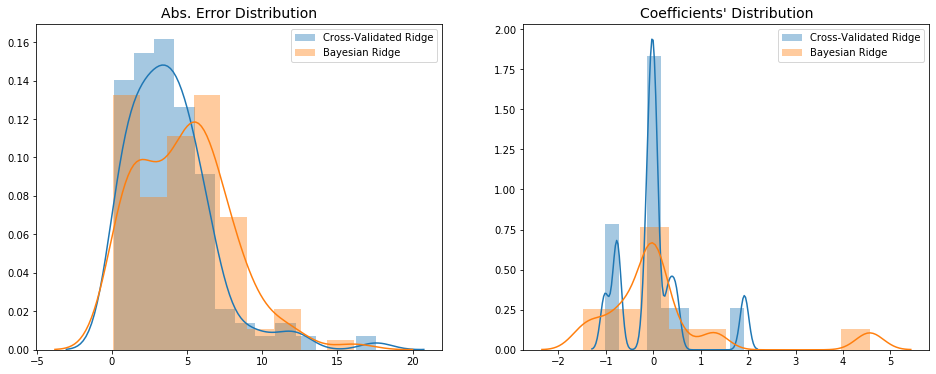

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.distplot(rr_error, label = 'Cross-Validated Ridge')
sns.distplot(brr_error, label = 'Bayesian Ridge')
plt.title('Abs. Error Distribution', size = 14)
plt.legend()

plt.subplot(122)
sns.distplot(rr.coef_, bins = 10, label = 'Cross-Validated Ridge')
sns.distplot(brr.coef_, bins = 10, label = 'Bayesian Ridge')
plt.title("Coefficients' Distribution", size = 14)
plt.legend();

***Error histograms are quite similar unlike the weight distributions of modelsоо. Pros and cons are discussed [here](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression), on the link you gave***

# Task 4. Stacking (2 point)

Stacking is another approach to combine several algorithms to get better results.Basically stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The main concept is to learn base models on some set of features then train meta model, which uses the predictions of base models as features. This technique is wiledly used in multiple real case scenarios to get better results. One of the main problem of stacking is, of course, overfitting. To avoid it, the training set is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models, and $ n $ -th for the overall prediction (calculating the meta-factor). In order to train the meta-model, it should receive predictions from the base models for those objects of the training sample on which the meta-model will be trained. 

There are various of stacking approaches$.^{[1]}$ For example, in order, to obtain meta-factors for test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers. If we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained$.^{[2]}$ You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.s. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer [source](https://www.quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning). Because they are so similar you can use any of them. 

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  
[2] MLgroup SHAD

**The task:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models (base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml,features e.t.c) and train them.
* Report individual scores on test set for each of the models. As a score use accuracy.
* Train metaclassifier on original datasets features, report score on test.
* Train meta_classifier on those base models. Report the test score (accuracy) in this case.
* Does stacking helped to gain better score?

Enough of theory, let's get back to Practice. Download dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype) and  split it train-test - 60/40.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

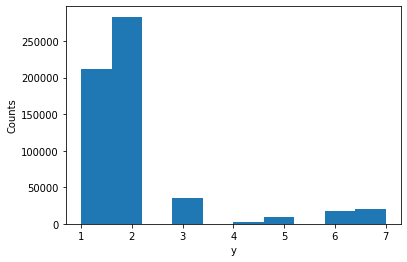

In [33]:
X,y = fetch_covtype('.', return_X_y=True, )

plt.figure()
plt.hist(y)
plt.xlabel('y')
plt.ylabel('Counts');

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.4, random_state=11)

Write meta classifier function.

In [35]:
###YOUR CODE###
# required imports
import copy
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
# to import from a separate file

class MetaClassifier:
    def __init__(self, base_learners, final_estimator):
        self.base_learners = copy.deepcopy(base_learners)
        self.final_estimator = copy.deepcopy(final_estimator)
        self.test_meta = None
        self.ready = False
    
    def fit(self, X_train, y_train, cv=5):
        train_meta = [[], np.array([])]
        kf = StratifiedKFold(cv, shuffle=True)
        for train_id, test_id in kf.split(X_train, y_train):
            rows = np.array([]).reshape(0, len(test_id))
            for C in self.base_learners:
                C.fit(X_train[train_id], y_train[train_id])
                y_pred = C.predict(X_train[test_id])
                rows = np.vstack((rows, y_pred))
            train_meta[0].append(rows.T)
            train_meta[1] = np.r_[train_meta[1], y_train[test_id]]
        train_meta[0] = np.vstack(train_meta[0])
        self.final_estimator.fit(*train_meta)
        self.ready = True
        
    def prepare_test_meta(self, X_test):
        if self.test_meta is None:
            self.test_meta = []
            try:
                for i, C in enumerate(self.base_learners):
                    C.fit(X_train, y_train)
                    self.test_meta.append(C.predict(X_test))
            except:
                print(f'Error: the {i}-th learner has not been able to fit') 
                self.test_meta = None
    
    def get_bl_scores(self, X_test, y_test, assess=accuracy_score):
        self.prepare_test_meta(X_test)
        scores = np.zeros(len(self.test_meta))
        for i, y_pred in enumerate(self.test_meta):
            scores[i] = assess(y_test, y_pred)
        return scores
        
    def predict(self, X_test):
        if not self.ready:
            raise Exception('Fit the model first')
        self.prepare_test_meta(X_test)
        test_meta = np.vstack(self.test_meta).T
        
        return self.final_estimator.predict(test_meta) 

Chose 6 different base models(base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml,features e.t.c) and train them. 

In [36]:
###YOUR CODE###
# first three give quite good adequate accuracy
# so one can take instead the last three repeatedly
# combining them with feature engineering and/or
# different hyperparameters
base_learners = [DecisionTreeClassifier(), 
                 ExtraTreeClassifier(),
                 KNeighborsClassifier(),
                 LinearDiscriminantAnalysis(),
                 RidgeClassifier(), 
                 GaussianNB()]

final_estimator = LogisticRegression(max_iter=1000, multi_class = 'multinomial')
mc = MetaClassifier(base_learners, final_estimator)

Report individual scores on test set. As a score use accuracy.

In [37]:
###YOUR CODE###
scores = mc.get_bl_scores(X_test, y_test)
names = map(lambda x: x.__class__.__name__, base_learners)
for i,(k,v) in enumerate(zip(names, scores)):
    indent = (32//len(k)+(i<3)) * '\t'
    print(f'{k}:{indent}{v:.2}')

DecisionTreeClassifier:		0.93
ExtraTreeClassifier:		0.86
KNeighborsClassifier:		0.96
LinearDiscriminantAnalysis:	0.68
RidgeClassifier:		0.7
GaussianNB:			0.46


Train metaclassifier on original datasets features. And report score on test.

In [38]:
###YOUR CODE###
final_estimator.fit(X_train, y_train)
y_pred = final_estimator.predict(X_test)
accuracy_score(y_test, y_pred)

 /home/lukoshkin/BuildPacks/miniconda3/envs/ml_2020/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning:lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6860179428153439

Train meta_classifier on those base models and report score (accuracy) on the test. 

In [40]:
###YOUR CODE###
mc.fit(X_train, y_train)
y_pred = mc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9386588068242938

Does stacking helped to gain better score?  
**Your answer:**

No, it does not. 3 of 6 base learners have a score higher than the stacked model. As can be seen from the class histogram, they are not balanced. However, I tested different scores (which take into account classes imbalance), it changed nothing. `StratifiedKFold` improves the situation a bit, but just slightly over a half of percent.

# Task 5. Gaussian Processes (1 point)

In the following exercise you will need to fit the gaussian process with different kernels on the ```elecricity_conpumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [41]:
data = pd.read_csv('data/elecricity_conpumption_FR.csv')
data.dropna(inplace=True)

In [42]:
y = np.array(data.values)
X = np.array(data.index)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.3)

X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.

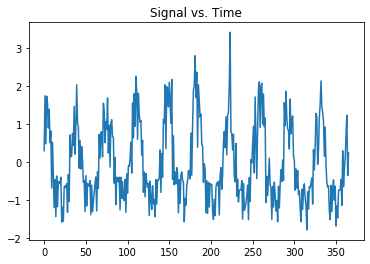

In [44]:
###YOUR CODE###
scaler = StandardScaler()
scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

plt.plot(X, np.r_[y_train, y_test])
plt.title('Signal vs. Time');

* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

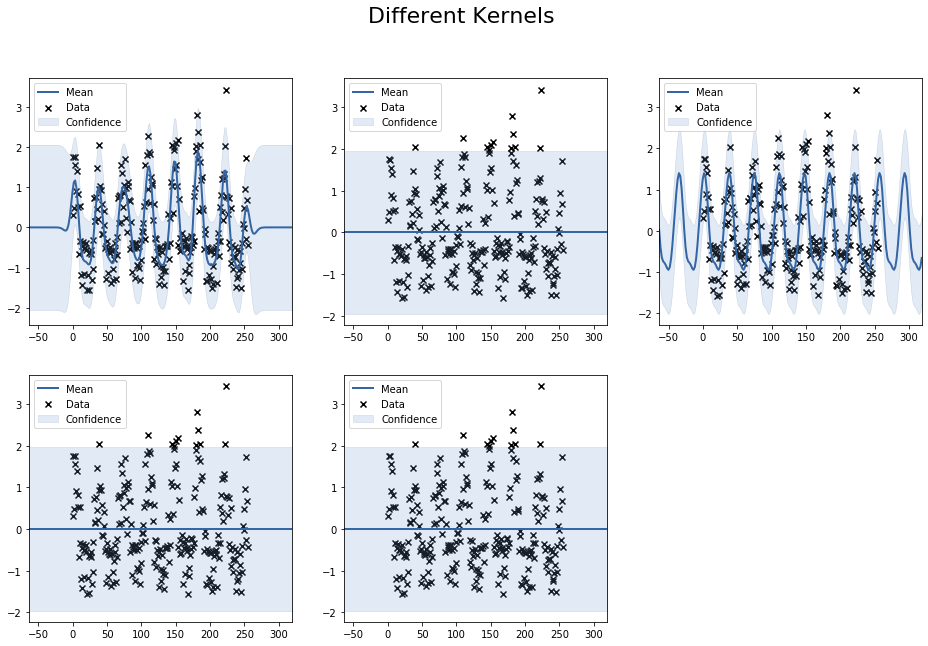

In [45]:
###YOUR CODE###
kernels = [RBF(input_dim=1),
           Poly(input_dim=1),
           StdPeriodic(input_dim=1),
           White(input_dim=1),
           Linear(input_dim=1)]

params = [[1., 1.],
          [1., 3., .1],
          [1., 33., 1.],
          [1.], [1.]]

for i, k in enumerate(kernels):
    for j, v in enumerate(k.parameter_names()):
        setattr(k, v, params[i][j])

plt.figure(figsize=(16, 10))
plt.suptitle('Different Kernels', size=22)
for i, k in enumerate(kernels):
    model = GPRegression(X_train, y_train, k)
    model.Gaussian_noise = 1.
    model.optimize()
    
    ax = plt.subplot(2, 3, i+1)
    model.plot(ax=ax)

r2_score: 0.7216447197254796


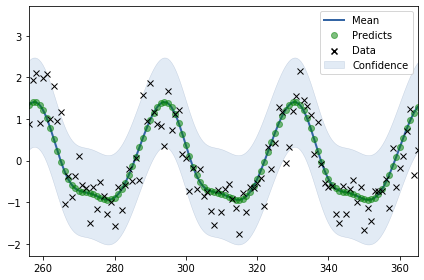

In [46]:
model = GPRegression(X_train, y_train, kernels[2])
model.optimize()

lims = (X_test.min(), X_test.max())
model.plot(plot_limits=lims)

y_pred,_ = model.predict(X_test)
ax = plt.gca()
ax.plot(X_test, y_pred, 'o', c='g', alpha=.5, label='Predicts')
ax.plot(X_test, y_test, 'x', c='black')
plt.legend();
print('r2_score:', r2_score(y_test, y_pred))